In [29]:
import os
import json
import pandas as pd
from neo4j import GraphDatabase
from pandas import DataFrame

In [30]:
dir = "/Users/nabhansuwanachote/Desktop/research/msr-2025-challenge/java-dependency-analyzer/new-dependency-output-6"

In [31]:
def list_directories(path):
    # List only directories
    directories = [os.path.join(path, d) for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    return directories

def list_files(directory):
    # List only files
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return files

def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)  # Parse JSON data
    return data

def convert_dependency_format_to_list(data):
    result = []
    for dependency in data:
        if ":" in dependency['artifact']:
            converted_artifact = ":".join(dependency['artifact'].split(':')[0:2])
            result.append(converted_artifact)
    return list(set(result))        

In [202]:
from datetime import datetime
import ast

class ComparedResult:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.df = pd.read_csv(csv_file)    
        
    def get_timestamp(self, release_id):
        artifact_id = ":".join(release_id.split(":")[0:2])
        version = release_id.split(":")[-1]
        row = self.df[self.df['artifact_id'] == artifact_id]
        row = row.iloc[0]
        tags = ast.literal_eval(row['tags'])
        versions = ast.literal_eval(row['versions'])
        
        compared_result_list = []
        for entry in row["compared_result"]:
            compared_result_list.append(entry[0])
            
        for entry in versions:
            if entry["name"] == version:
                return entry["ts"]
    
        # Check in older_tags
        for entry in tags:
            if entry["name"] == version:
                iso_date = entry["date"]
                timestamp = int(datetime.strptime(iso_date, "%Y-%m-%dT%H:%M:%SZ").timestamp()) * 1000
                return timestamp
    
        # If not found
        return None
    
    def get_first_timestamp(self, release_id):
        artifact_id = ":".join(release_id.split(":")[0:2])
        version = release_id.split(":")[-1]
        row = self.df[self.df['artifact_id'] == artifact_id]
        row = row.iloc[0]
        tags = ast.literal_eval(row['tags'])
        versions = ast.literal_eval(row['versions'])   
        
        success_file = [file.split(".json")[0] for file in list_files(dir + "/" + artifact_id)]
            
        version_with_ts = []
        for entry in versions:
            if entry["name"] in success_file:
                version_with_ts.append({"name": entry["name"], "ts": int(entry["ts"])})
    
        # Check in older_tags
        for entry in tags:
            if entry["name"] in success_file:
                iso_date = entry["date"]
                ts = int(datetime.strptime(iso_date, "%Y-%m-%dT%H:%M:%SZ").timestamp()) * 1000
                if not any(existing_entry["name"] == entry["name"] for existing_entry in version_with_ts):
                    version_with_ts.append({"name": entry["name"], "ts": ts})
            
        sorted_version = sorted(version_with_ts, key=lambda x: x["ts"])
    
        # If not found
        return sorted_version[0]["ts"]
    
    def get_current_version_index(self, release_id):
        artifact_id = ":".join(release_id.split(":")[0:2])
        version = release_id.split(":")[-1]
        row = self.df[self.df['artifact_id'] == artifact_id]
        row = row.iloc[0]
        tags = ast.literal_eval(row['tags'])
        versions = ast.literal_eval(row['versions'])   
        
        success_file = [file.split(".json")[0] for file in list_files(dir + "/" + artifact_id)]
            
        version_with_ts = []
        for entry in versions:
            if entry["name"] in success_file:
                version_with_ts.append({"name": entry["name"], "ts": int(entry["ts"])})
    
        # Check in older_tags
        for entry in tags:
            if entry["name"] in success_file:
                iso_date = entry["date"]
                ts = int(datetime.strptime(iso_date, "%Y-%m-%dT%H:%M:%SZ").timestamp()) * 1000
                if not any(existing_entry["name"] == entry["name"] for existing_entry in version_with_ts):
                    version_with_ts.append({"name": entry["name"], "ts": ts})
            
        sorted_version = sorted(version_with_ts, key=lambda x: x["ts"])
        for i, entry in enumerate(sorted_version):
            if entry["name"] == version:
                return i          
        return None

In [33]:
class Neo4jDriver:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def get_timestamp(self, release_id):
        query = """
        MATCH (r:Release {id: $release_id})
        RETURN r.timestamp
        """
        with self.driver.session() as session:
            # Execute the query and return the results
            results = session.run(query, release_id=release_id)
            return [record["r.timestamp"] for record in results][0]

In [34]:
class ProjectReport:
    artifact = ""
    dir = ""
    timestamp = ""
    introduce_unused_dependency = []
    introduce_unused_dependency_but_import = []
    unused_previously_used = []
    unused_previously_used_but_import = []
    unused_dependency = []
    use_dependency = []
    use_transitive_dependency = []
    
    def __init__(self, artifact, introduce_unused_dependency, introduce_unused_dependency_but_import, unused_previously_used, unused_previously_used_but_import, unused_dependency, unused_but_import, use_dependency, use_transitive_dependency):
        self.artifact = artifact
        self.introduce_unused_dependency = introduce_unused_dependency
        self.introduce_unused_dependency_but_import = introduce_unused_dependency_but_import
        self.unused_previously_used = unused_previously_used
        self.unused_previously_used_but_import = unused_previously_used_but_import
        self.unused_dependency = unused_dependency
        self.unused_but_import = unused_but_import
        self.use_dependency = use_dependency
        self.use_transitive_dependency = use_transitive_dependency
        
    def convert_to_df(self):
        artifact_id = ":".join(self.artifact.split(":")[0:2])
        version = self.artifact.split(":")[2]
        data = {
            "artifact": artifact_id,
            "version": version,
            "introduce_unused_dependency": len(self.introduce_unused_dependency),
            "introduce_unused_dependency_but_import": len(self.introduce_unused_dependency_but_import),
            "introduce_unused_previously_used": len(self.unused_previously_used),
            "introduce_unused_but_import_previously_used": len(self.unused_previously_used_but_import),
            "unused_dependency": len(self.unused_dependency),
            "unused_dependency_but_import": len(self.unused_but_import),
            "use_dependency": len(self.use_dependency),
            "use_transitive_dependency": len(self.use_transitive_dependency),
        }
        return pd.DataFrame(data, index=[0])
        

In [35]:
list_directories(dir)

['/Users/nabhansuwanachote/Desktop/research/msr-2025-challenge/java-dependency-analyzer/new-dependency-output-6/nl.hsac:hsac-fitnesse-email',
 '/Users/nabhansuwanachote/Desktop/research/msr-2025-challenge/java-dependency-analyzer/new-dependency-output-6/io.github.stefanofornari:vfs2nio',
 '/Users/nabhansuwanachote/Desktop/research/msr-2025-challenge/java-dependency-analyzer/new-dependency-output-6/com.squareup.pagerduty:pagerduty-incidents',
 '/Users/nabhansuwanachote/Desktop/research/msr-2025-challenge/java-dependency-analyzer/new-dependency-output-6/uk.co.rgordon:oj-ssh',
 '/Users/nabhansuwanachote/Desktop/research/msr-2025-challenge/java-dependency-analyzer/new-dependency-output-6/de.vandermeer:ascii-utf-themes',
 '/Users/nabhansuwanachote/Desktop/research/msr-2025-challenge/java-dependency-analyzer/new-dependency-output-6/io.quarkus.qlue:qlue',
 '/Users/nabhansuwanachote/Desktop/research/msr-2025-challenge/java-dependency-analyzer/new-dependency-output-6/com.forgerock.openbanking:o

In [36]:
success_project = pd.read_csv(dir + "/success_project.csv")
# success_project = pd.read_csv("temp.csv")
success_path_list = []
for index, row in success_project.iterrows():
    success_path_list.append(row["artifact_id"])

success_path_list

['org.terrakube.terraform:terraform-spring-boot-autoconfigure',
 'nl.axians:axians-opentelemetry-spring-boot-starter',
 'com.geetask:chunked-uploader',
 'com.geetask:chunked-uploader',
 'net.distilledcode:filevault-oak-reindex-hook',
 'org.java-websocket:Java-WebSocket',
 'com.github.doobo:openpdf-ivs',
 'com.github.robtimus:obfuscation-json',
 'com.s24:redjob',
 'org.sourcelab:kafka-webview-ui',
 'io.github.hiskrtapps:apocalypse-dao-springjdbc',
 'net.cactusthorn.config:jasypt',
 'nl.hsac:hsac-fitnesse-email',
 'cz.alry:plantuml-maven-plugin',
 'com.charlyghislain.authenticator:authenticator-application-api',
 'media.pepperpot.tca:tomcat-jwt-authenticator',
 'ch.rasc:wampspring',
 'com.github.bartlomiej-gora:RPNLibrary',
 'be.idamediafoundry.sofa:mapper-api',
 'se.sawano.eureka:legacy-registrar',
 'io.split.integrations.azure:azure-spring-cloud-feature-management',
 'io.probedock.rt.client:probedock-rt-itf',
 'org.ibboost.orqa:orqa-maven-plugin',
 'com.github.usc:wechat-mp-sdk',
 'org

In [37]:
len(success_path_list)

418

In [38]:
success_project

,artifact_id,repo_path
0,org.terrakube.terraform:terraform-spring-boot-...,/Users/nabhansuwanachote/Desktop/research/msr-...
1,nl.axians:axians-opentelemetry-spring-boot-sta...,/Users/nabhansuwanachote/Desktop/research/msr-...
2,com.geetask:chunked-uploader,/Users/nabhansuwanachote/Desktop/research/msr-...
3,com.geetask:chunked-uploader,/Users/nabhansuwanachote/Desktop/research/msr-...
4,net.distilledcode:filevault-oak-reindex-hook,/Users/nabhansuwanachote/Desktop/research/msr-...
...,...,...
413,com.github.livesense:org.liveSense.service.sec...,/Users/nabhansuwanachote/Desktop/research/msr-...
414,cz.etnetera:reesmo-adapter-junit,/Users/nabhansuwanachote/Desktop/research/msr-...
415,org.jboss.pnc:pnc-api,/Users/nabhansuwanachote/Desktop/research/msr-...
416,jp.igapyon.blanco.apex.formatter.plugin:blanco...,/Users/nabhansuwanachote/Desktop/research/msr-...


In [39]:
# success_project.to_csv("temp.csv")

In [40]:
# driver = Neo4jDriver("bolt://localhost:7687", "neo4j", "12345678")
filtered_directories = []
compare_result = ComparedResult("data_with_date/success-compared-result-2.csv")

for directory in list_directories(dir):
    if (directory.split("/")[-1] in success_path_list):
        filtered_directories.append(directory)

project_result = {}
count = 0
for project_dir in filtered_directories:
    list_of_files = list_files(project_dir)
    data_with_timestamp = []
    project_report = []
    project_id = ":".join(read_json_file(os.path.join(project_dir, list_of_files[0]))["projectArtifact"].split(":")[0:2])
    for file in list_of_files:
        data = read_json_file(os.path.join(project_dir, file))
        artifact_id = data["projectArtifact"]
        timestamp = compare_result.get_timestamp(artifact_id)
        data_with_timestamp.append((data, timestamp))
    data_with_timestamp.sort(key=lambda x: x[1])
    
    for index, data in enumerate(data_with_timestamp):
        current_data = data[0]
        artifact_id = current_data["projectArtifact"]
        current_unused_dependency = current_data["projectUnusedDependencies"]
        current_use_dependency = current_data["projectUseDependencies"]
        current_use_transitive_dependency = current_data["projectUseTransitiveDependencies"]
        converted_unused_dependency = list(set(convert_dependency_format_to_list(current_unused_dependency)))
        converted_use_dependency = list(set(convert_dependency_format_to_list(current_use_dependency)))
        converted_use_transitive_dependency = list(set(convert_dependency_format_to_list(current_use_transitive_dependency)))
        file_import_reports = current_data["fileImportReports"]
        
        unused_import_artifact = []
        for import_report in file_import_reports:
            unused_import_report = import_report["unusedImportReport"]
            for unused_import in unused_import_report:
                artifact = unused_import["artifact"]
                result = convert_dependency_format_to_list([artifact])
                if len(result) > 0:
                    unused_import_artifact.append(result[0])
                    
        introduce_unused_but_import = []
        unused_but_import_previously_used = []
        
        # Count unused but imported
        unused_but_imported = []
        for unused_dependency in converted_unused_dependency:
            if unused_dependency in unused_import_artifact:
                unused_but_imported.append(unused_dependency)
                
        
        # Count introduce unused dependency
        introduce_unused = []
        unused_previously_used = []
        if index == 0:
            # First version
            for unused_dep in converted_unused_dependency:
                introduce_unused.append(unused_dep)
                if unused_dep in unused_import_artifact:
                    introduce_unused_but_import.append(unused_dep)
        else:
            previous_data = data_with_timestamp[index - 1][0]
            previous_unused_dependency = previous_data["projectUnusedDependencies"]
            previous_use_dependency = previous_data["projectUseDependencies"]
            previous_use_transitive_dependency = previous_data["projectUseTransitiveDependencies"]
            all_previous_dependency = previous_unused_dependency + previous_use_dependency + previous_use_transitive_dependency
            all_previous_use_dependency = previous_use_dependency + previous_use_transitive_dependency
            converted_all_previous_dependency = list(set(convert_dependency_format_to_list(all_previous_dependency)))
            converted_all_previous_use_dependency = list(set(convert_dependency_format_to_list(all_previous_use_dependency)))
            
            for unused_dep in converted_unused_dependency:
                if unused_dep not in converted_all_previous_dependency:
                    introduce_unused.append(unused_dep)
                    if unused_dep in unused_import_artifact:
                        introduce_unused_but_import.append(unused_dep)
                elif unused_dep in converted_all_previous_use_dependency:
                    unused_previously_used.append(unused_dep)
                    if unused_dep in unused_import_artifact:
                        unused_but_import_previously_used.append(unused_dep)
        
        report = ProjectReport(artifact_id, introduce_unused, introduce_unused_but_import, unused_previously_used, unused_but_import_previously_used, converted_unused_dependency, unused_but_imported, converted_use_dependency, converted_use_transitive_dependency)
        project_report.append(report)
    project_result[project_id] = project_report

print(len(project_result))

417


In [41]:
df_list = []

for k, v in project_result.items():
    for project in v:
        df_list.append(project.convert_to_df())

concat_df = pd.concat(df_list, axis=0, ignore_index=True)
concat_df["all_introduce"] = concat_df["introduce_unused_dependency"] + concat_df["introduce_unused_previously_used"]
concat_df["all_dependency"] = concat_df["use_dependency"] + concat_df["use_transitive_dependency"] + concat_df["unused_dependency"]
concat_df

,artifact,version,introduce_unused_dependency,introduce_unused_dependency_but_import,introduce_unused_previously_used,introduce_unused_but_import_previously_used,unused_dependency,unused_dependency_but_import,use_dependency,use_transitive_dependency,all_introduce,all_dependency
0,nl.hsac:hsac-fitnesse-email,0.0.1,1,0,0,0,1,0,2,0,1,3
1,nl.hsac:hsac-fitnesse-email,0.1.0,0,0,0,0,1,0,2,0,0,3
2,nl.hsac:hsac-fitnesse-email,0.2.0,0,0,0,0,1,0,2,0,0,3
3,nl.hsac:hsac-fitnesse-email,0.3.0,0,0,0,0,1,0,2,0,0,3
4,nl.hsac:hsac-fitnesse-email,0.4.0,0,0,0,0,0,0,2,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
3015,dev.mccue:guava,0.0.5,0,0,0,0,13,0,0,0,0,13
3016,dev.mccue:guava,33.1.0,0,0,0,0,13,0,0,0,0,13
3017,dev.mccue:guava,33.2.0,0,0,0,0,13,0,0,0,0,13
3018,org.openstates:openstates-client,1.0.0,0,0,0,0,0,0,1,0,0,1


In [42]:
concat_df_result = concat_df.groupby("artifact").agg(
    introduce_unused_dependency_sum=pd.NamedAgg(column="introduce_unused_dependency", aggfunc="sum"),
    introduce_unused_dependency_but_import_sum=pd.NamedAgg(column="introduce_unused_dependency_but_import", aggfunc="sum"),
    introduce_unused_previously_use = pd.NamedAgg(column="introduce_unused_previously_used", aggfunc="sum"),
    introduce_unused_but_import_previously_used = pd.NamedAgg(column="introduce_unused_but_import_previously_used", aggfunc="sum"),
    total_unused_dependency = pd.NamedAgg(column="unused_dependency", aggfunc="sum"),
    total_unused_dependency_but_import = pd.NamedAgg(column="unused_dependency_but_import", aggfunc="sum"),
    total_use_transitive_dependency = pd.NamedAgg(column="use_transitive_dependency", aggfunc="sum"),
    median_unused_dependency = pd.NamedAgg(column="unused_dependency", aggfunc="median"),
    average_unused_dependency=pd.NamedAgg(column="unused_dependency", aggfunc="mean"),
    average_unused_dependency_but_import = pd.NamedAgg(column="unused_dependency_but_import", aggfunc="mean"),
    average_use_transitive_dependency=pd.NamedAgg(column="use_transitive_dependency", aggfunc="mean"),
    dependency_count = pd.NamedAgg(column="all_dependency", aggfunc="mean"),
    version_count=pd.NamedAgg(column="version", aggfunc="count"),
)

concat_df_result["version_count"] = concat_df_result["version_count"]

# Display the result
# concat_df_result.to_csv("data/temp.csv")
concat_df_result

,introduce_unused_dependency_sum,introduce_unused_dependency_but_import_sum,introduce_unused_previously_use,introduce_unused_but_import_previously_used,total_unused_dependency,total_unused_dependency_but_import,total_use_transitive_dependency,median_unused_dependency,average_unused_dependency,average_unused_dependency_but_import,average_use_transitive_dependency,dependency_count,version_count
artifact,,,,,,,,,,,,,
am.ik.yavi:yavi,3,0,0,0,120,0,0,3.0,1.935484,0.0,0.0,2.677419,62
at.makubi.maven.plugin:avrohugger-maven-plugin,4,0,0,0,10,0,0,2.5,2.500000,0.0,0.0,5.000000,4
at.molindo:molindo-amazonclient,0,0,0,0,0,0,0,0.0,0.000000,0.0,0.0,1.000000,1
at.molindo:molindo-mysql-collations,2,0,0,0,2,0,0,2.0,2.000000,0.0,0.0,4.000000,1
at.yawk.numaec:numa-eclipse-collections,0,0,0,0,0,0,0,0.0,0.000000,0.0,0.0,1.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
uk.co.modular-it:bean-utils,0,0,0,0,0,0,0,0.0,0.000000,0.0,0.0,2.000000,9
uk.co.rgordon:oj-ant,2,0,0,0,2,0,0,2.0,2.000000,0.0,0.0,5.000000,1
uk.co.rgordon:oj-ssh,1,0,0,0,1,0,0,1.0,1.000000,0.0,0.0,5.000000,1


In [43]:
statistics = {
    "min": concat_df_result.min(numeric_only=True),
    "mean": concat_df_result.mean(numeric_only=True),
    "median": concat_df_result.median(numeric_only=True),
    "max": concat_df_result.max(numeric_only=True),
    "total": concat_df_result.sum(numeric_only=True),
}
stats_df = pd.DataFrame(statistics)

# Display the statistics table
stats_df

,min,mean,median,max,total
introduce_unused_dependency_sum,0.000000,1.218225,1.000000,16.000000,508.000000
introduce_unused_dependency_but_import_sum,0.000000,0.009592,0.000000,1.000000,4.000000
introduce_unused_previously_use,0.000000,0.071942,0.000000,5.000000,30.000000
introduce_unused_but_import_previously_used,0.000000,0.004796,0.000000,1.000000,2.000000
total_unused_dependency,0.000000,7.371703,1.000000,350.000000,3074.000000
total_unused_dependency_but_import,0.000000,0.050360,0.000000,11.000000,21.000000
total_use_transitive_dependency,0.000000,3.707434,0.000000,275.000000,1546.000000
median_unused_dependency,0.000000,0.965228,0.000000,13.000000,402.500000
average_unused_dependency,0.000000,0.956491,0.157895,13.000000,398.856587
average_unused_dependency_but_import,0.000000,0.011101,0.000000,1.000000,4.629167


In [69]:
statistics = {
    "min": concat_df.min(numeric_only=True),
    "mean": concat_df.mean(numeric_only=True),
    "median": concat_df.median(numeric_only=True),
    "max": concat_df.max(numeric_only=True),
    "total": concat_df.sum(numeric_only=True),
}

stats_df = pd.DataFrame(statistics)

# Display the statistics table
stats_df

,min,mean,median,max,total
introduce_unused_dependency,0,0.168212,0.0,13,508
introduce_unused_dependency_but_import,0,0.001325,0.0,1,4
introduce_unused_previously_used,0,0.009934,0.0,2,30
introduce_unused_but_import_previously_used,0,0.000662,0.0,1,2
unused_dependency,0,1.017881,0.0,13,3074
unused_dependency_but_import,0,0.006954,0.0,1,21
use_dependency,0,3.681457,2.0,48,11118
use_transitive_dependency,0,0.511921,0.0,10,1546
all_introduce,0,0.178146,0.0,13,538
all_dependency,0,5.211258,4.0,64,15738


In [47]:
group_df = concat_df.groupby("artifact").sum()
print(len(group_df[group_df["all_introduce"] > 0])/len(group_df))

0.5203836930455635


In [48]:
len(concat_df[concat_df["all_introduce"] > 0])/len(concat_df)

0.09304635761589404

In [49]:
print(len(group_df))

417


In [52]:
rq2_project_result = {}
for k, v in project_result.items():
    if k in concat_df["artifact"].tolist():
        rq2_project_result[k] = v

In [53]:
rq2_project_result

{'nl.hsac:hsac-fitnesse-email': [<__main__.ProjectReport at 0x11f353320>,
 'io.github.stefanofornari:vfs2nio': [<__main__.ProjectReport at 0x1779d5f10>,
 'com.squareup.pagerduty:pagerduty-incidents': [<__main__.ProjectReport at 0x1779d5250>,
 'uk.co.rgordon:oj-ssh': [<__main__.ProjectReport at 0x1779d56d0>],
 'de.vandermeer:ascii-utf-themes': [<__main__.ProjectReport at 0x1779d5670>],
 'io.quarkus.qlue:qlue': [<__main__.ProjectReport at 0x1779d5700>,
 'com.forgerock.openbanking:openbanking-sdk': [<__main__.ProjectReport at 0x1779d5910>,
 'de.jpdigital:hibernate6-ddl-maven-plugin-core': [<__main__.ProjectReport at 0x1779d45c0>,
 'com.github.kasiprasad.contextspec:contextspec': [<__main__.ProjectReport at 0x1779d45f0>],
 'io.github.eduramiba:webcam-capture-driver-native': [<__main__.ProjectReport at 0x1779d6300>],
 'org.mapdb:mapdb-hz-offheap': [<__main__.ProjectReport at 0x1779d4620>,
 'com.pastdev:jsch-nio': [<__main__.ProjectReport at 0x1779d5ac0>,
 'tech.energyit:fast-java-statsd-cli

## RQ2

In [54]:
class ArtifactExistReport:
    def __init__(self, project_id, artifact_id, from_ts, to_ts, from_version, to_version, version_different, last_state):
        self.project_id = project_id
        self.artifact_id = artifact_id
        self.from_ts = from_ts
        self.to_ts = to_ts
        self.last_state = last_state
        self.from_version = from_version
        self.to_version = to_version
        self.version_different = version_different
        
    def convert_to_df(self):
        duration = None
        if self.to_ts != None:
            duration = self.to_ts - self.from_ts
        data = {
            "project_id": self.project_id,
            "artifact": self.artifact_id,
            "from_ts": self.from_ts,
            "to_ts": self.to_ts,
            "last_state": self.last_state,
            "from_version": self.from_version,
            "to_version": self.to_version,
            "version_different": self.version_different,
            "duration": duration,
        }
        return pd.DataFrame(data, index=[0])
    

In [116]:
# driver = Neo4jDriver("bolt://localhost:7687", "neo4j", "12345678")


def find_evolution(current_index, last_index, project_result, unused_artifact_id, project_id):
    from_ts = project_result[current_index].timestamp
    from_version = project_result[current_index].artifact.split(":")[2]
    for i in range(current_index + 1, last_index + 1):
        current_project_result = project_result[i]
        if unused_artifact_id in current_project_result.unused_dependency:
            continue
        if unused_artifact_id in current_project_result.use_dependency or unused_artifact_id in current_project_result.use_transitive_dependency:
            to_version = current_project_result.artifact.split(":")[2]
            return ArtifactExistReport(project_id, unused_artifact_id, from_ts, current_project_result.timestamp, from_version, to_version, i - current_index, "use later")
        to_version = current_project_result.artifact.split(":")[2]
        return ArtifactExistReport(project_id, unused_artifact_id, from_ts, current_project_result.timestamp, from_version, to_version, i - current_index, "removed")
    return ArtifactExistReport(project_id, unused_artifact_id, from_ts, None, from_version, None, None, "stay there")
        

how_long_exist = {}
for project_id, project_reports in rq2_project_result.items():
    result = []
    for project_report in project_reports:
        ts =  compare_result.get_timestamp(project_report.artifact)
        project_report.timestamp = ts
        
    last_index = len(project_reports) - 1
    for index, project_report in enumerate(project_reports):
        for current_unused in project_report.introduce_unused_dependency:
            result.append(find_evolution(index, last_index, project_reports, current_unused, project_id))
        for current_unused in project_report.unused_previously_used:
            result.append(find_evolution(index, last_index, project_reports, current_unused, project_id))
    if len(result) > 0:
        how_long_exist[project_id] = result
            
            
print(how_long_exist)

KeyboardInterrupt: 

In [70]:
how_long_exist

{'nl.hsac:hsac-fitnesse-email': [<__main__.ArtifactExistReport at 0x17794e120>],
 'com.squareup.pagerduty:pagerduty-incidents': [<__main__.ArtifactExistReport at 0x17794ee40>,
 'uk.co.rgordon:oj-ssh': [<__main__.ArtifactExistReport at 0x17794d460>],
 'io.quarkus.qlue:qlue': [<__main__.ArtifactExistReport at 0x17794e5d0>,
 'com.forgerock.openbanking:openbanking-sdk': [<__main__.ArtifactExistReport at 0x17794df70>,
 'de.jpdigital:hibernate6-ddl-maven-plugin-core': [<__main__.ArtifactExistReport at 0x17794fb30>,
 'io.github.eduramiba:webcam-capture-driver-native': [<__main__.ArtifactExistReport at 0x17794fa40>],
 'com.github.foxty:topaz': [<__main__.ArtifactExistReport at 0x17794f320>,
 'org.kuali.db.ojb:db-ojb': [<__main__.ArtifactExistReport at 0x17797e8d0>,
 'org.emfjson:emfjson-mongo': [<__main__.ArtifactExistReport at 0x17794ee70>],
 'cn.dustlight.storage:minio-storage': [<__main__.ArtifactExistReport at 0x17797e510>],
 'org.dbtools:dbtools-jpa': [<__main__.ArtifactExistReport at 0x1

In [71]:
report_df_list = []

for k, v in how_long_exist.items():
    for artifact_report in v:
        report_df_list.append(artifact_report.convert_to_df())
        
artifact_reports = pd.concat(report_df_list, axis=0, ignore_index=True)
artifact_reports

,project_id,artifact,from_ts,to_ts,last_state,from_version,to_version,version_different,duration
0,nl.hsac:hsac-fitnesse-email,org.fitnesse:fitnesse,1512902820000,1573307166000,use later,0.0.1,0.4.0,4,60404346000
1,com.squareup.pagerduty:pagerduty-incidents,com.google.code.gson:gson,1443029646000,1443031154000,removed,1.1.0,1.1.1,1,1508000
2,com.squareup.pagerduty:pagerduty-incidents,com.google.code.gson:gson,1443035854000,None,stay there,2.0.0-beta1,None,None,None
3,uk.co.rgordon:oj-ssh,org.openjdk.nashorn:nashorn-core,1674342182000,None,stay there,1.6.0,None,None,None
4,io.quarkus.qlue:qlue,io.smallrye.common:smallrye-common-function,1604559409000,None,stay there,0.9.0,None,None,None
...,...,...,...,...,...,...,...,...,...
533,dev.mccue:guava,dev.mccue:guava-reflect,1690819812000,None,stay there,0.0.1,None,None,None
534,dev.mccue:guava,dev.mccue:guava-html,1690819812000,None,stay there,0.0.1,None,None,None
535,dev.mccue:guava,dev.mccue:guava-io,1690819812000,None,stay there,0.0.1,None,None,None
536,dev.mccue:guava,dev.mccue:guava-xml,1690819812000,None,stay there,0.0.1,None,None,None


In [58]:
#  t = t.groupby("artifact").agg(
#     introduce_unused_dependency_sum=pd.NamedAgg(column="introduce_unused_dependency", aggfunc="sum"),
#     introduce_unused_dependency_but_import_sum=pd.NamedAgg(column="introduce_unused_dependency_but_import", aggfunc="sum"),
#     average_unused_dependency=pd.NamedAgg(column="unused_dependency", aggfunc="mean"),
#     average_use_transitive_dependency=pd.NamedAgg(column="use_transitive_dependency", aggfunc="mean"),
#     version_count=pd.NamedAgg(column="version", aggfunc="count"),
#     use_transitive_dependency_sum=pd.NamedAgg(column="use_transitive_dependency", aggfunc="sum"),
#     use_dependency_sum=pd.NamedAgg(column="use_dependency", aggfunc="sum"),
# )
 
group_by_state_artifact_report = artifact_reports.groupby("last_state").agg(
    count=pd.NamedAgg(column="artifact", aggfunc="count"),
)

In [59]:
group_by_state_artifact_report

,count
last_state,
removed,75
stay there,410
use later,53


# Find first introduction date

In [209]:
from datetime import datetime

In [206]:
result = []
compare_result = ComparedResult("data_with_date/success-compared-result-2.csv")
for project_id, project_reports in rq2_project_result.items():
    for project_report in project_reports:
        ts =  compare_result.get_timestamp(project_report.artifact)
        project_report.timestamp = ts
        
    for index, project_report in enumerate(project_reports):
        current_index = compare_result.get_current_version_index(project_report.artifact)
        first_ts = compare_result.get_first_timestamp(project_report.artifact)
        for current_unused in project_report.introduce_unused_dependency:
            result.append({"project_id": project_id, "artifact_id": project_report.artifact, "unused_dependency": current_unused, "timestamp": project_report.timestamp, "first_timestamp": first_ts, "version": current_index + 1})
        for current_unused in project_report.unused_previously_used:
            result.append({"project_id": project_id, "artifact_id": project_report.artifact, "unused_dependency": current_unused, "timestamp": project_report.timestamp, "first_timestamp": first_ts, "version": current_index + 1})
    
    

In [204]:

ComparedResult("data_with_date/success-compared-result-2.csv").get_current_version_index("com.azure.resourcemanager:azure-resourcemanager-datadog:1.0.0")

4

In [210]:
df = pd.DataFrame(result)
df

,project_id,artifact_id,unused_dependency,timestamp,first_timestamp,version
0,nl.hsac:hsac-fitnesse-email,nl.hsac:hsac-fitnesse-email:0.0.1,org.fitnesse:fitnesse,1512902820000,1512902820000,1
1,com.squareup.pagerduty:pagerduty-incidents,com.squareup.pagerduty:pagerduty-incidents:1.1.0,com.google.code.gson:gson,1443029646000,1407995756000,3
2,com.squareup.pagerduty:pagerduty-incidents,com.squareup.pagerduty:pagerduty-incidents:2.0...,com.google.code.gson:gson,1443035854000,1407995756000,5
3,uk.co.rgordon:oj-ssh,uk.co.rgordon:oj-ssh:1.6.0,org.openjdk.nashorn:nashorn-core,1674342182000,1674342182000,1
4,io.quarkus.qlue:qlue,io.quarkus.qlue:qlue:0.9.0,io.smallrye.common:smallrye-common-function,1604559409000,1604559409000,1
...,...,...,...,...,...,...
533,dev.mccue:guava,dev.mccue:guava:0.0.1,dev.mccue:guava-reflect,1690819812000,1690819812000,1
534,dev.mccue:guava,dev.mccue:guava:0.0.1,dev.mccue:guava-html,1690819812000,1690819812000,1
535,dev.mccue:guava,dev.mccue:guava:0.0.1,dev.mccue:guava-io,1690819812000,1690819812000,1
536,dev.mccue:guava,dev.mccue:guava:0.0.1,dev.mccue:guava-xml,1690819812000,1690819812000,1


In [217]:
for index, row in df.iterrows():
    first_ts = datetime.fromtimestamp(row["first_timestamp"]/1000)
    current_ts = datetime.fromtimestamp(row["timestamp"]/1000)
    diff_time = current_ts - first_ts
    df.at[index, "diff_days"] = diff_time.days
    
    year_diff = current_ts.year - first_ts.year
    month_diff = current_ts.month - first_ts.month
    total_month_diff = year_diff * 12 + month_diff
    
    df.at[index, "diff_year"] = year_diff + 1
    df.at[index, "diff_month"] = total_month_diff

In [220]:
df

,project_id,artifact_id,unused_dependency,timestamp,first_timestamp,version,diff_days,diff_year,diff_month
0,nl.hsac:hsac-fitnesse-email,nl.hsac:hsac-fitnesse-email:0.0.1,org.fitnesse:fitnesse,1512902820000,1512902820000,1,0.0,1.0,0.0
1,com.squareup.pagerduty:pagerduty-incidents,com.squareup.pagerduty:pagerduty-incidents:1.1.0,com.google.code.gson:gson,1443029646000,1407995756000,3,405.0,2.0,13.0
2,com.squareup.pagerduty:pagerduty-incidents,com.squareup.pagerduty:pagerduty-incidents:2.0...,com.google.code.gson:gson,1443035854000,1407995756000,5,405.0,2.0,13.0
3,uk.co.rgordon:oj-ssh,uk.co.rgordon:oj-ssh:1.6.0,org.openjdk.nashorn:nashorn-core,1674342182000,1674342182000,1,0.0,1.0,0.0
4,io.quarkus.qlue:qlue,io.quarkus.qlue:qlue:0.9.0,io.smallrye.common:smallrye-common-function,1604559409000,1604559409000,1,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
533,dev.mccue:guava,dev.mccue:guava:0.0.1,dev.mccue:guava-reflect,1690819812000,1690819812000,1,0.0,1.0,0.0
534,dev.mccue:guava,dev.mccue:guava:0.0.1,dev.mccue:guava-html,1690819812000,1690819812000,1,0.0,1.0,0.0
535,dev.mccue:guava,dev.mccue:guava:0.0.1,dev.mccue:guava-io,1690819812000,1690819812000,1,0.0,1.0,0.0
536,dev.mccue:guava,dev.mccue:guava:0.0.1,dev.mccue:guava-xml,1690819812000,1690819812000,1,0.0,1.0,0.0


In [219]:
len(df[df["diff_year"] == 1])/len(df) * 100

79.92565055762083

In [221]:
len(df[df["version"] == 1]) / len(df) * 100

69.51672862453532

## Resolved artifact report

In [74]:
resolved_artifact_report = artifact_reports[artifact_reports["last_state"].isin(["removed", "use later"])]
resolved_artifact_report['duration_day'] = resolved_artifact_report['duration']/(1000 * 60 * 60 * 24)
resolved_artifact_report = resolved_artifact_report[["duration_day", "version_different"]]
resolved_artifact_report

/var/folders/qn/b44z9ynj1j1_3c888q5nw9s00000gn/T/ipykernel_12979/193858687.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resolved_artifact_report['duration_day'] = resolved_artifact_report['duration']/(1000 * 60 * 60 * 24)


,duration_day,version_different
0,699.124375,4
1,0.017454,1
7,372.96735,34
22,16.622118,1
24,129.124988,1
...,...,...
512,966.27294,2
518,48.317963,3
519,502.322049,29
520,502.322049,29


In [75]:
stats_table = resolved_artifact_report.agg(['min', 'mean', 'median', 'max'])

stats_table_transposed = stats_table.T
stats_table_transposed

,min,mean,median,max
duration_day,0.006134,369.611834,210.639861,2499.004132
version_different,1.000000,5.679688,2.000000,41.000000


## Removed artifact report

In [60]:
artifact_reports[artifact_reports["last_state"] == "removed"]

,project_id,artifact,from_ts,to_ts,last_state,from_version,to_version,version_different,duration
1,com.squareup.pagerduty:pagerduty-incidents,com.google.code.gson:gson,1443029646000,1443031154000,removed,1.1.0,1.1.1,1,1508000
24,org.kuali.db.ojb:db-ojb,torque:torque,1296852210000,1308008609000,removed,1.0.4-patch6,1.0.4-patch7,1,11156399000
47,com.github.josefd8:gingerspec,com.jayway.restassured:json-schema-validator,1568024521000,1586416231000,removed,untagged-66b81f2b9695ed12748b,untagged-3e52c03288686417458b,6,18391710000
55,org.sentrysoftware.maven:maven-skin-tools,org.apache.maven:maven-project,1698768786000,1698778175000,removed,1.0.00,1.1.00,1,9389000
56,org.sentrysoftware.maven:maven-skin-tools,org.apache.maven.doxia:doxia-decoration-model,1698768786000,1698778175000,removed,1.0.00,1.1.00,1,9389000
...,...,...,...,...,...,...,...,...,...
486,net.code-story:fluent-rest-test,org.assertj:assertj-core,1422375792000,1425981977000,removed,1.2,1.3,1,3606185000
500,at.makubi.maven.plugin:avrohugger-maven-plugin,com.julianpeeters:avrohugger-filesorter_2.11,1505657426000,1633187005000,removed,1.4,1.7,3,127529579000
519,com.s24:redjob,org.apache.logging.log4j:log4j-core,1466495383000,1509896008000,removed,0.0.2,0.4.1,29,43400625000
520,com.s24:redjob,org.apache.logging.log4j:log4j-slf4j-impl,1466495383000,1509896008000,removed,0.0.2,0.4.1,29,43400625000


In [61]:
removed_artifact_report = artifact_reports[artifact_reports["last_state"] == "removed"]
removed_artifact_report['duration_day'] = removed_artifact_report['duration']/(1000 * 60 * 60 * 24)
removed_artifact_report = removed_artifact_report[["duration_day", "version_different"]]
removed_artifact_report

/var/folders/qn/b44z9ynj1j1_3c888q5nw9s00000gn/T/ipykernel_12979/1535701394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed_artifact_report['duration_day'] = removed_artifact_report['duration']/(1000 * 60 * 60 * 24)


,duration_day,version_different
1,0.017454,1
24,129.124988,1
47,212.867014,6
55,0.108669,1
56,0.108669,1
...,...,...
486,41.738252,1
500,1476.036794,3
519,502.322049,29
520,502.322049,29


In [62]:
removed_artifact_report.to_csv("removed_artifact_report.csv")

In [64]:
stats_table = removed_artifact_report.agg(['min', 'mean', 'median', 'max'])

stats_table_transposed = stats_table.T
stats_table_transposed

,min,mean,median,max
duration_day,0.006134,410.949316,208.412708,2499.004132
version_different,1.000000,5.026667,2.000000,29.000000


## Use later artifact report

In [65]:
artifact_reports[artifact_reports["last_state"] == "use later"]

,project_id,artifact,from_ts,to_ts,last_state,from_version,to_version,version_different,duration
0,nl.hsac:hsac-fitnesse-email,org.fitnesse:fitnesse,1512902820000,1573307166000,use later,0.0.1,0.4.0,4,60404346000
7,com.forgerock.openbanking:openbanking-sdk,io.springfox:springfox-swagger-ui,1510050109000,1542274488000,use later,1.1.0.0,3.0.0.7,34,32224379000
22,org.kuali.db.ojb:db-ojb,p6spy:p6spy,1295416059000,1296852210000,use later,db-ojb-1.0.4-patch5,1.0.4-patch6,1,1436151000
32,org.jamesframework:james-examples,org.jamesframework:james-extensions,1403700571000,1415812996000,use later,0.1,0.2,1,12112425000
38,com.github.josefd8:gingerspec,com.fasterxml.jackson.core:jackson-core,1556775020000,1616665670000,use later,untagged-0df9d744eb48e54583fc,2.2.1-RC1,28,59890650000
39,com.github.josefd8:gingerspec,org.aspectj:aspectjweaver,1556775020000,1589106219000,use later,untagged-0df9d744eb48e54583fc,untagged-5157804818edfe608738,20,32331199000
40,com.github.josefd8:gingerspec,org.postgresql:postgresql,1556775020000,1570671268000,use later,untagged-0df9d744eb48e54583fc,untagged-9bfbc16e6a4d1e1de61e,10,13896248000
41,com.github.josefd8:gingerspec,mysql:mysql-connector-java,1556775020000,1652065910000,use later,untagged-0df9d744eb48e54583fc,2.2.12,41,95290890000
45,com.github.josefd8:gingerspec,com.google.guava:guava,1557962232000,1570671268000,use later,untagged-d6f69e0fe142640a222a,untagged-9bfbc16e6a4d1e1de61e,8,12709036000
48,com.github.josefd8:gingerspec,org.postgresql:postgresql,1589106219000,1631758059000,use later,untagged-5157804818edfe608738,2.2.10,19,42651840000


In [66]:
use_later_artifact_report = artifact_reports[artifact_reports["last_state"] == "use later"]
use_later_artifact_report['duration_day'] = use_later_artifact_report['duration']/(1000 * 60 * 60 * 24)
use_later_artifact_report = use_later_artifact_report[["duration_day", "version_different"]]
use_later_artifact_report

/var/folders/qn/b44z9ynj1j1_3c888q5nw9s00000gn/T/ipykernel_12979/4281174026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_later_artifact_report['duration_day'] = use_later_artifact_report['duration']/(1000 * 60 * 60 * 24)


,duration_day,version_different
0,699.124375,4
7,372.96735,34
22,16.622118,1
32,140.190104,1
38,693.178819,28
39,374.203692,20
40,160.836204,10
41,1102.903819,41
45,147.095324,8
48,493.655556,19


In [67]:
use_later_artifact_report.to_csv("use_later_artifact_report.csv")

In [68]:
stats_table = use_later_artifact_report.agg(['min', 'mean', 'median', 'max'])

stats_table_transposed = stats_table.T
stats_table_transposed

,min,mean,median,max
duration_day,3.959201,311.115398,255.980729,1936.031111
version_different,1.000000,6.603774,2.000000,41.000000


## Mann-Whiteney U test

In [76]:
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 28.8 MB/s eta 0:00:0000:0100:01


In [77]:
import scipy.stats._mannwhitneyu

In [85]:
from scipy.stats import mannwhitneyu
u_statictic, p_value = mannwhitneyu(use_later_artifact_report['duration_day'].tolist(), removed_artifact_report['duration_day'].tolist(), alternative='two-sided')
print(u_statictic, p_value)

2031.0 0.8352066551093437


In [86]:
u_statictic, p_value = mannwhitneyu(use_later_artifact_report['version_different'].tolist(), removed_artifact_report['version_different'].tolist(), alternative='two-sided')
print(u_statictic, p_value)

2006.0 0.9289317410789308


## Plot graph

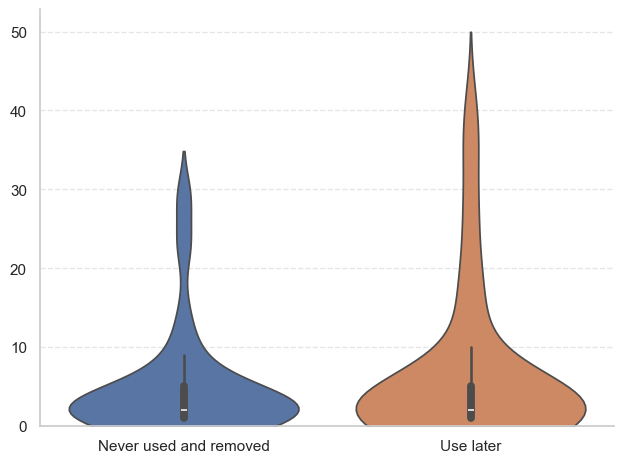

In [223]:
import seaborn as sns
import matplotlib.pyplot as plt


version_different_violin_plot = DataFrame({
    "Never used and removed": removed_artifact_report["version_different"],
    "Use later": use_later_artifact_report["version_different"],
})

sns.set_theme(style="whitegrid")
sns.violinplot(data=version_different_violin_plot)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
plt.ylim(0, None)
plt.tight_layout()
plt.show()

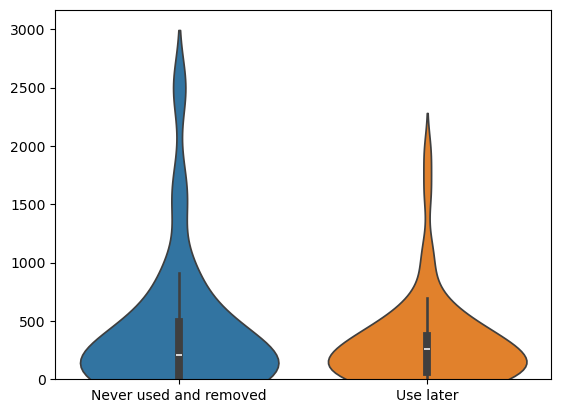

In [218]:
version_duration_plot = DataFrame({
    "Never used and removed": removed_artifact_report["duration_day"],
    "Use later": use_later_artifact_report["duration_day"],
})

sns.violinplot(data=version_duration_plot)
plt.ylim(0, None)
plt.show()

In [215]:
removed_artifact_report[removed_artifact_report["version_different"] < 0]

,duration_day,version_different
